# Dataset exploration

## import packages

In [716]:
import gzip
import json
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import random
import string
from sklearn import linear_model
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from scipy.optimize import fmin_l_bfgs_b
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from collections import Counter
from surprise import SVD, Reader, Dataset
from surprise.accuracy import rmse, mae
from scipy.sparse import lil_matrix
from scipy.sparse import hstack, csr_matrix
from fastFM import als

## Import Dataset

In [717]:
data_path = 'renttherunway_final_data.json.gz'

In [718]:
def readGz(path):
     g = gzip.open(path, 'r')
     for l in g:
        l = str(json.loads(l))
        yield eval(l)

In [719]:
data = []
for l in readGz(data_path):
    data.append(l)

In [720]:
data[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

In [721]:
df = pd.DataFrame(data)

In [722]:
display(df)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192539,fit,66386,34dd,2252812,140lbs,10,work,Fit like a glove!,hourglass,LOVE IT!!! First Item Im thinking of buying!,jumpsuit,"5' 9""",8,42,"May 18, 2016"
192540,fit,118398,32c,682043,100lbs,10,work,The pattern contrast on this dress is really s...,petite,LOVE it!,dress,"5' 1""",4,29,"September 30, 2016"
192541,fit,47002,36a,683251,135lbs,6,everyday,"Like the other DVF wraps, the fit on this is f...",straight & narrow,"Loud patterning, flattering fit",dress,"5' 8""",8,31,"March 4, 2016"
192542,fit,961120,36c,126335,165lbs,10,wedding,This dress was PERFECTION. it looked incredib...,pear,loved this dress it was comfortable and photog...,dress,"5' 6""",16,31,"November 25, 2015"


In [723]:
print("\nDataset info: \n")
print(df.info())


Dataset info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   fit             192544 non-null  object
 1   user_id         192544 non-null  object
 2   bust size       174133 non-null  object
 3   item_id         192544 non-null  object
 4   weight          162562 non-null  object
 5   rating          192462 non-null  object
 6   rented for      192534 non-null  object
 7   review_text     192544 non-null  object
 8   body type       177907 non-null  object
 9   review_summary  192544 non-null  object
 10  category        192544 non-null  object
 11  height          191867 non-null  object
 12  size            192544 non-null  int64 
 13  age             191584 non-null  object
 14  review_date     192544 non-null  object
dtypes: int64(1), object(14)
memory usage: 22.0+ MB
None


In [724]:
print("\nDataset null data sum: \n")
print(df.isnull().sum())


Dataset null data sum: 

fit                   0
user_id               0
bust size         18411
item_id               0
weight            29982
rating               82
rented for           10
review_text           0
body type         14637
review_summary        0
category              0
height              677
size                  0
age                 960
review_date           0
dtype: int64


## Dataset Description

The dataset we have chosen to work with contains measurements of clothing fit from RentTheRunaway, which is an e-commerce platform that allow users to rent and purchase clothings, accessories and more for work, special events and everyday wear. 

The total number of observations that have been gathered for this specific dataset is 192544, which we decided was an appropriate number of observations and enough interactions between users and items to perform a correct data analysis and model building. 

The attributes of the dataset include:
| Column Name      | Data Type | # of Null | Description                                                                                               |
|------------------|-----------|-----------|-----------------------------------------------------------------------------------------------------------|
| fit              | object    | 0         | Indicates whether the fit was as expected, tight, or loose.                                               |
| user_id          | object    | 0         | Unique identifier for the user who submitted the review.                                                  |
| bust size        | object    | 18411     | The bust size of the user, typically given in formats like "34d".                                         |
| item_id          | object    | 0         | Unique identifier for the item being reviewed.                                                            |
| weight           | object    | 29982     | The weight of the user, typically in formats like "137lbs".                                               |
| rating           | object    | 82        | The rating given by the user for the item, typically on a scale of 1 to 10, incremented by 2                               |
| rented for       | object    | 10        | Purpose for which the item was rented, e.g., vacation, formal event, etc.                                 |
| review_text      | object    | 0         | The detailed text of the user's review about the item.                                                    |
| body type        | object    | 14637     | The body type of the user, e.g., hourglass, athletic, pear-shaped, etc.                                   |
| review_summary   | object    | 0         | A brief summary of the user's review.                                                                     |
| category         | object    | 0         | The category of the item being reviewed, e.g., romper, dress, etc.                                        |
| height           | object    | 677       | The height of the user, typically in formats like "5' 8\"".                                               |
| size             | int64     | 0         | The size of the item rented by the user, typically as a numeric value.                                    |
| age              | object    | 960       | The age of the user, typically in years.                                                                  |
| review_date      | object    | 0         | The date the review was submitted, typically in formats like "April 20, 2016".   

The attributes which have null values are bust size, weight, rating, rented for, body type, height, and age.

In [725]:
def convert_weight(weight):
    if pd.isnull(weight):
        return None
    if isinstance(weight, float):
        return weight
    return float(weight.replace('lbs', '').strip())

In [726]:
def convert_height(height):
    if pd.isnull(height):
        return None
    if isinstance(height, float) or isinstance(height, int):
        return height
    feet, inches = height.split("'")
    feet = int(feet.strip())
    inches = int(inches.replace('"', '').strip())
    return feet * 12 + inches

In [727]:
def convert_to_float(x):
    if pd.isnull(x):
        return None
    try:
        return float(x)
    except (TypeError, ValueError): 
        return x

In [728]:
print(df['bust size'].unique())

['34d' '34b' nan '34c' '32b' '34d+' '36d' '36a' '32d+' '36c' '32c' '32dd'
 '30dd' '32d' '36b' '34a' '34dd' '40ddd/e' '32a' '38d+' '38c' '34ddd/e'
 '38a' '38b' '38d' '36ddd/e' '38dd' '38f' '42dd' '36dd' '40g' '40dd' '28f'
 '30ddd/e' '32ddd/e' '28b' '36d+' '40d' '28dd' '34f' '42c' '30d' '30b'
 '42d' '34aa' '32aa' '36f' '28c' '40b' '36aa' '34g' '32f' '42ddd/e' '40c'
 '28g' '28aa' '36g' '30a' '44ddd/e' '30c' '30aa' '44dd' '32i' '32g' '30g'
 '38h' '30h' '34j' '38ddd/e' '32h' '28a' '44d' '40h' '38g' '34h' '36j'
 '40f' '36h' '28ddd/e' '44f' '34i' '30f' '36i' '30i' '28h' '42b' '42j'
 '32j' '46c' '48d' '38aa' '38i' '48dd' '28d' '28i' '46ddd/e' '42g' '44c'
 '42f' '40j' '38j' '46f' '44b' '44g' '42h' '40i' '44h']


In [729]:
rating_map = {'2' : 1, '4' : 2, '6' : 3, '8' : 4, '10' : 5}

In [730]:
df['weight'] = df['weight'].apply(convert_weight)
df['height'] = df['height'].apply(convert_height)
df['rating'] = df['rating'].map(rating_map)
#df['rating'] = df['rating'].apply(convert_to_float)
df['age'] = df['age'].apply(convert_to_float)

In [731]:
print(df.dtypes)

fit                object
user_id            object
bust size          object
item_id            object
weight            float64
rating            float64
rented for         object
review_text        object
body type          object
review_summary     object
category           object
height            float64
size                int64
age               float64
review_date        object
dtype: object


## Data cleanup
- We have decided to drop all rows with null values for convenience, since we should still have 76% of the original data (including null), which is approximately around 150k, to work with. 

In [732]:
missing_rows_count = df.isnull().any(axis=1).sum()
total_rows = len(df)
print(f"{missing_rows_count}/{total_rows} rows have missing values ({(missing_rows_count/total_rows)*100:.2f}%).")

46163/192544 rows have missing values (23.98%).


In [733]:
df = df.dropna()
df = df.reset_index(drop=True)

In [734]:
print(df.shape)

(146381, 15)


In [735]:
display(df.head())

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137.0,5.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132.0,5.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,"June 18, 2013"
2,fit,909926,34c,126335,135.0,4.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,"February 12, 2014"
3,fit,151944,34b,616682,145.0,5.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,"September 26, 2016"
4,fit,734848,32b,364092,138.0,4.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,68.0,8,45.0,"April 30, 2016"


## Data distributions

- Analyze the distribution of each attributes

In [736]:
print(df['fit'].unique())

['fit' 'small' 'large']


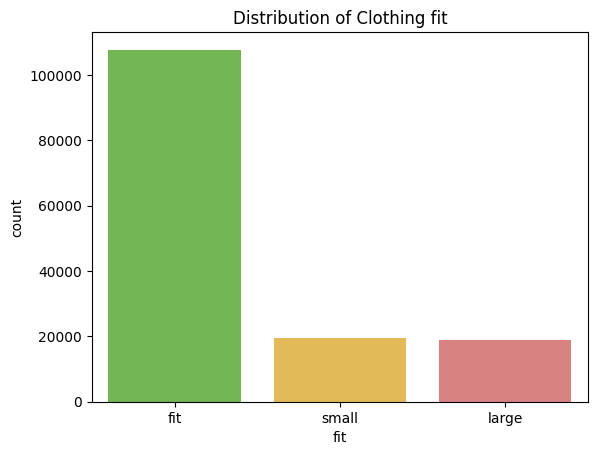

In [737]:
data_example = df
fit_distribution = data_example['fit'].value_counts()
fit_df = fit_distribution.reset_index()


custom_palette = {'fit': '#6cc644', 'small': '#f9c440', 'large': '#e57373'}
sns.barplot(x='fit', y='count', data=fit_df, palette=custom_palette, hue='fit', legend=False)
plt.title('Distribution of Clothing fit')
plt.show()


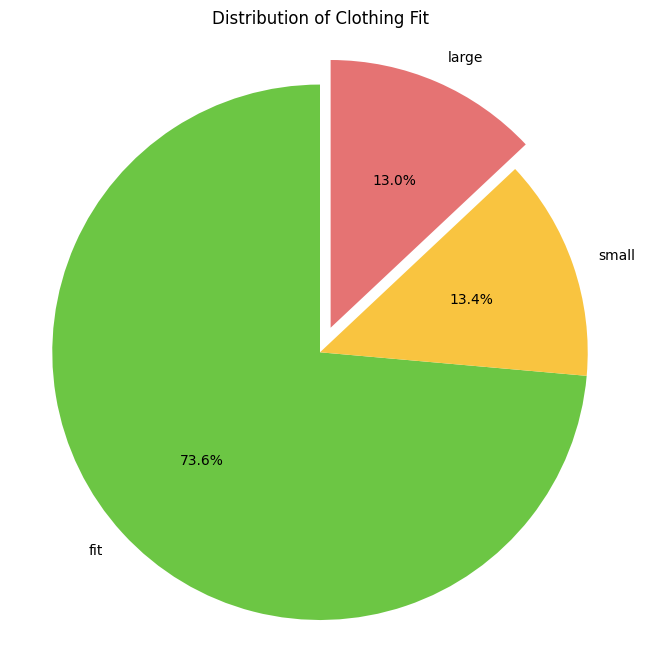

In [738]:
labels = fit_distribution.index 
sizes = fit_distribution.values 
colors = ['#6cc644', '#f9c440', '#e57373'] 
explode = [0.1 if label == 'large' else 0 for label in labels]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode)
plt.title('Distribution of Clothing Fit')
plt.axis('equal')  
plt.show()

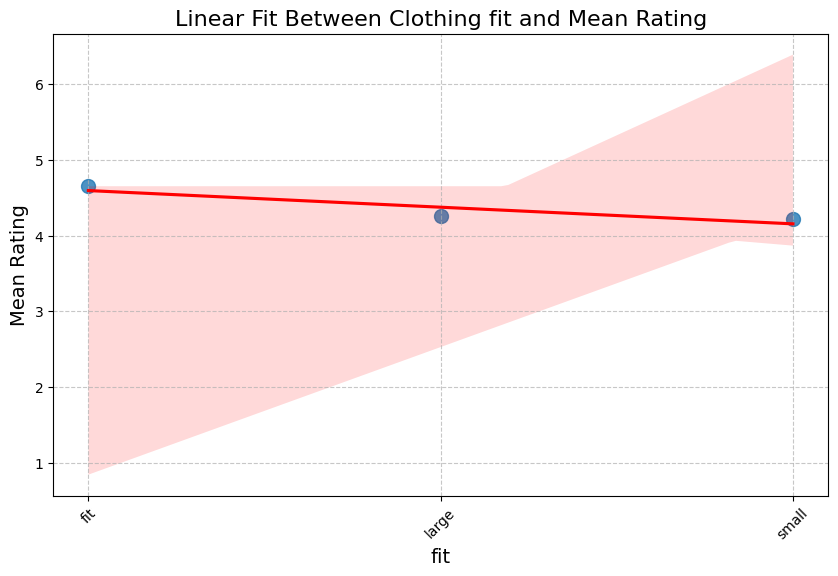

In [739]:
fit_rating = df.groupby('fit')['rating'].mean().reset_index()
le = LabelEncoder()
fit_rating['fit encoded'] = le.fit_transform(fit_rating['fit'])

plt.figure(figsize=(10, 6))
sns.regplot(data=fit_rating, x='fit encoded', y='rating', scatter_kws={'s': 100}, line_kws={'color': 'red'})
plt.xticks(ticks=fit_rating['fit encoded'], labels=fit_rating['fit'], rotation=45)
plt.title('Linear Fit Between Clothing fit and Mean Rating', fontsize=16)
plt.xlabel('fit', fontsize=14)
plt.ylabel('Mean Rating', fontsize=14)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

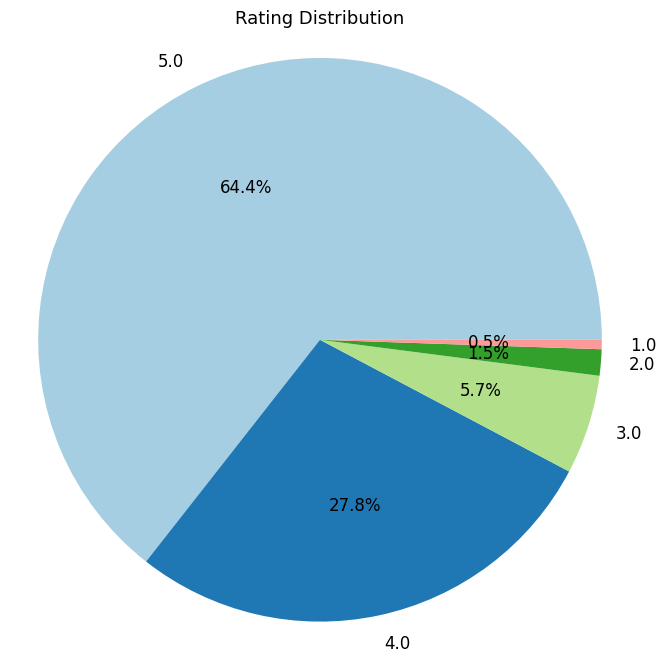

In [740]:
rating_counts = data_example['rating'].value_counts()

labels = rating_counts.index
sizes = rating_counts.values
colors = plt.cm.Paired(range(len(labels)))

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, textprops={'fontsize': 12})
plt.title('Rating Distribution', fontsize=13)
plt.axis('equal')
plt.show()

In [741]:
print(len(df['bust size'].unique()))

101


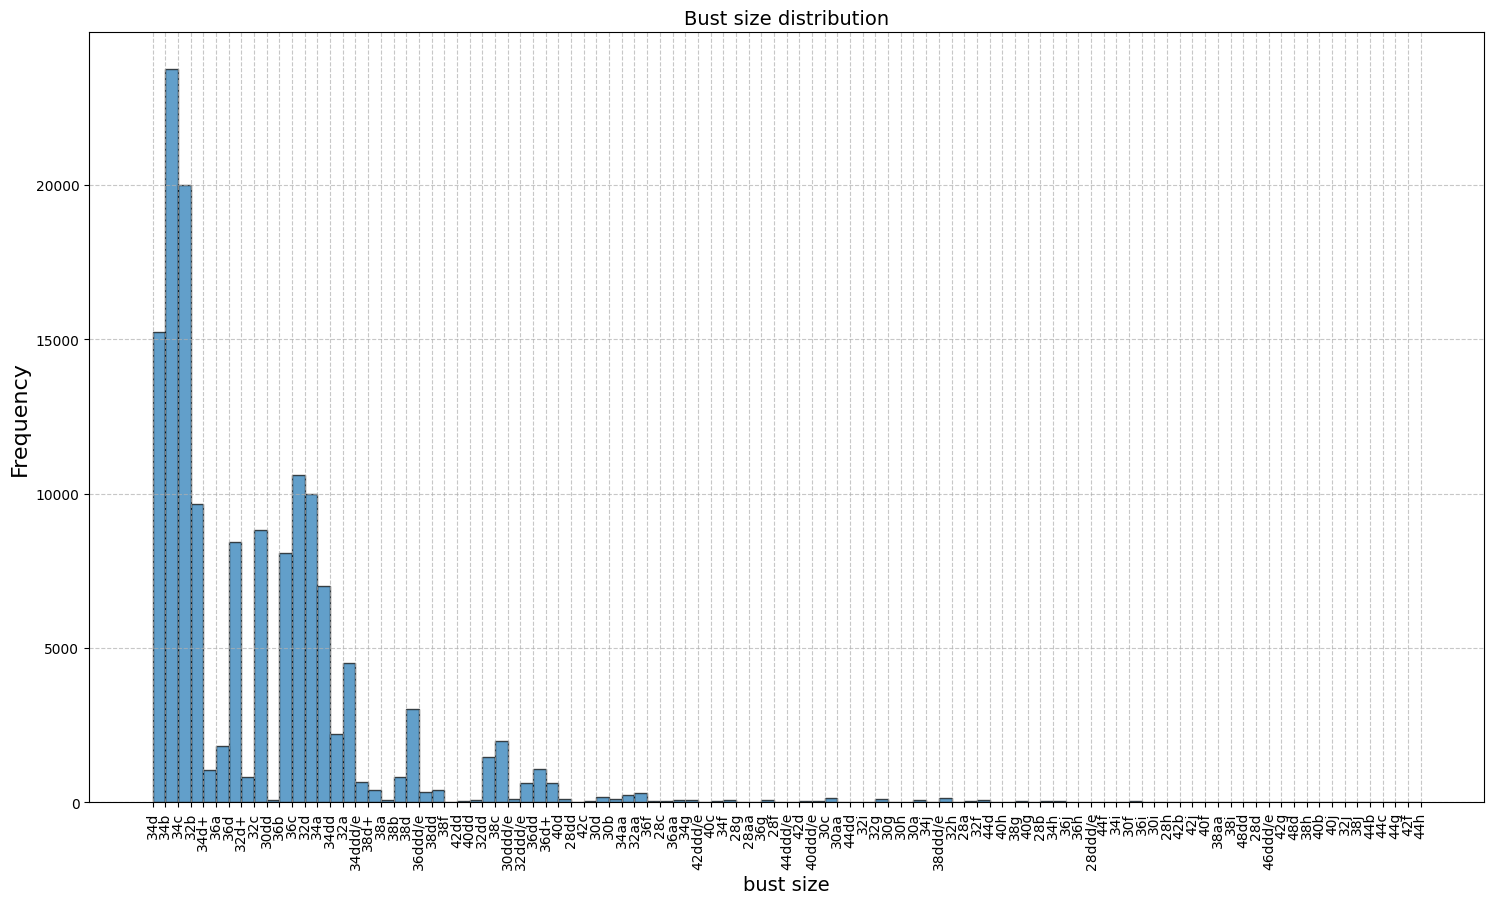

In [742]:
# Bust size distribution

plt.figure(figsize=(18, 10))
plt.hist(data_example['bust size'], bins=100, edgecolor='black', alpha=0.7)  
plt.title('Bust size distribution', fontsize=14)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('bust size', fontsize=14)
plt.xticks(rotation=90)
plt.grid(axis='both', linestyle='--', alpha=0.7)

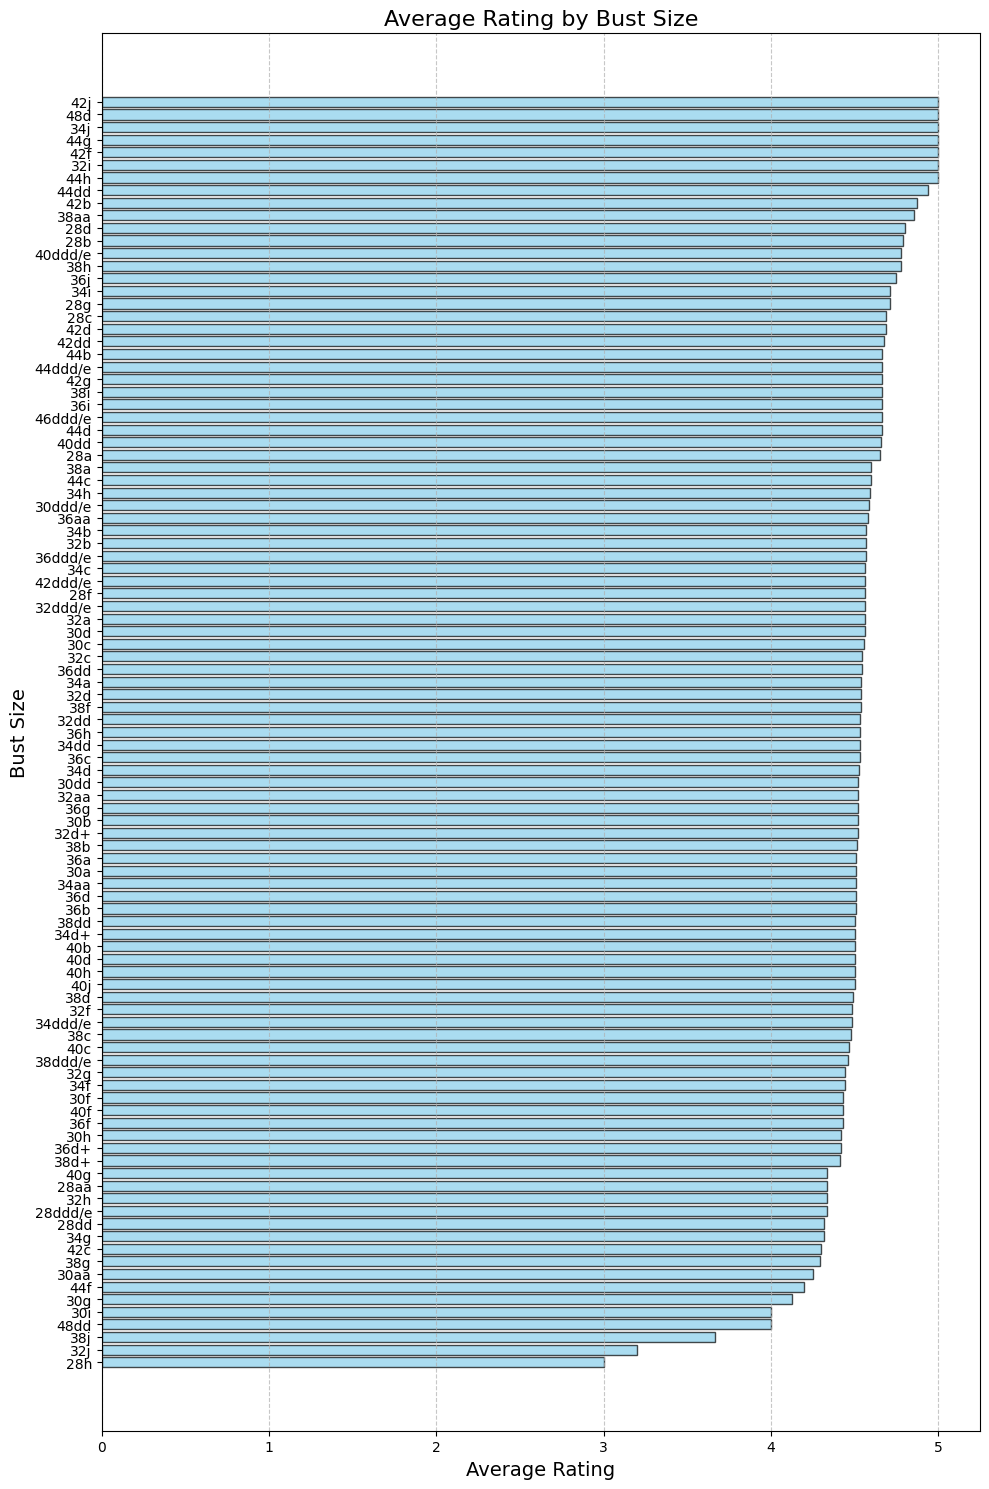

In [743]:
bust_size_avg_rating = data_example.groupby('bust size')['rating'].mean()
bust_size_avg_rating_sorted = bust_size_avg_rating.sort_values(ascending=True)
plt.figure(figsize=(10, 15))
plt.barh(bust_size_avg_rating_sorted.index, bust_size_avg_rating_sorted.values, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Average Rating by Bust Size', fontsize=16)
plt.xlabel('Average Rating', fontsize=14)
plt.ylabel('Bust Size', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [744]:
df['rented for'].unique()

array(['vacation', 'other', 'formal affair', 'wedding', 'date',
       'everyday', 'party', 'work', 'party: cocktail'], dtype=object)

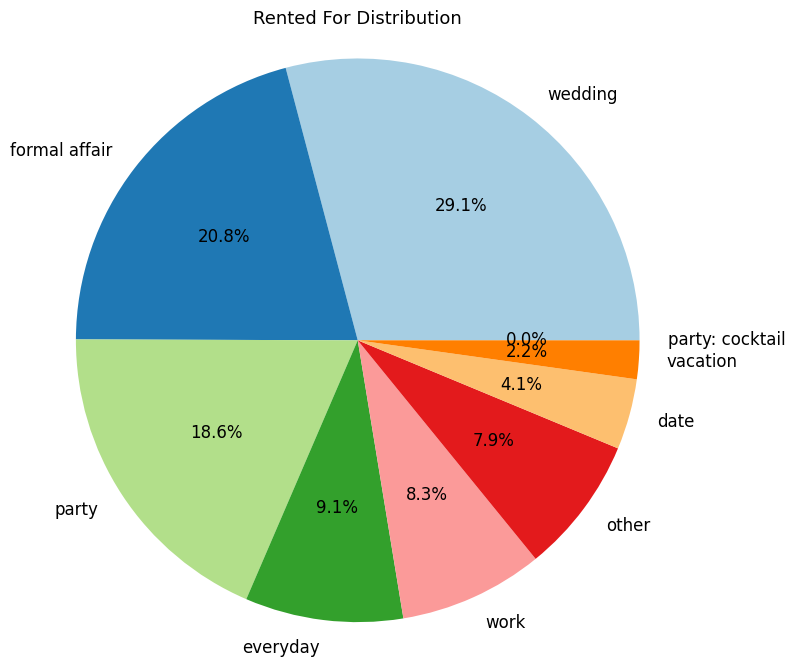

In [745]:
rented_for_counts = df['rented for'].value_counts()
rented_for_counts = rented_for_counts[rented_for_counts > 0]
labels = rented_for_counts.index
sizes = rented_for_counts.values
colors = plt.cm.Paired(range(len(labels)))

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, textprops={'fontsize': 12})
plt.title('Rented For Distribution', fontsize=13)
plt.axis('equal')
plt.show()

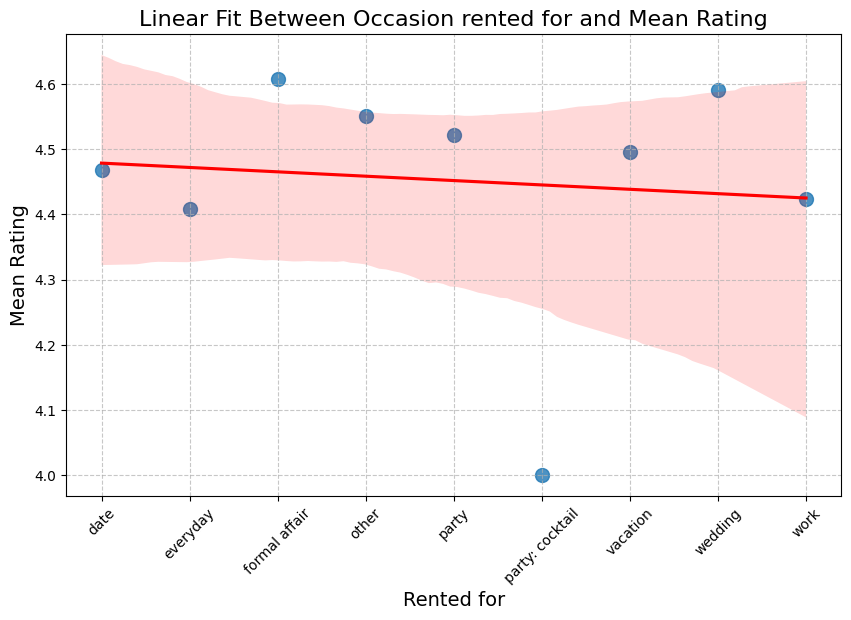

In [746]:
rentfor_rating = df.groupby('rented for')['rating'].mean().reset_index()
le = LabelEncoder()
rentfor_rating['rented for encoded'] = le.fit_transform(rentfor_rating['rented for'])

plt.figure(figsize=(10, 6))
sns.regplot(data=rentfor_rating, x='rented for encoded', y='rating', scatter_kws={'s': 100}, line_kws={'color': 'red'})
plt.xticks(ticks=rentfor_rating['rented for encoded'], labels=rentfor_rating['rented for'], rotation=45)
plt.title('Linear Fit Between Occasion rented for and Mean Rating', fontsize=16)
plt.xlabel('Rented for', fontsize=14)
plt.ylabel('Mean Rating', fontsize=14)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

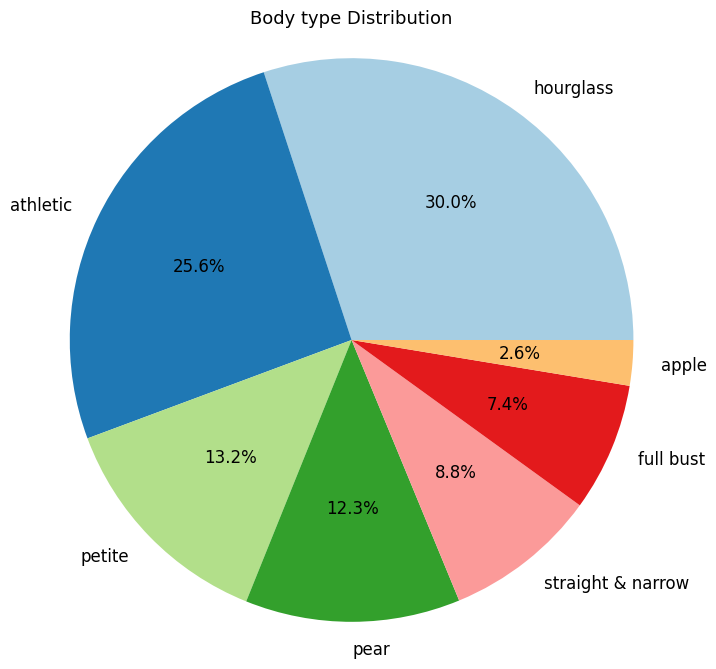

In [747]:
# Body type distribution
bodytype_counts = df['body type'].value_counts()
bodytype_counts = bodytype_counts[bodytype_counts > 0]

labels = bodytype_counts.index
sizes = bodytype_counts.values
colors = plt.cm.Paired(range(len(labels)))

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, textprops={'fontsize': 12})
plt.title('Body type Distribution', fontsize=13)
plt.axis('equal')
plt.show()

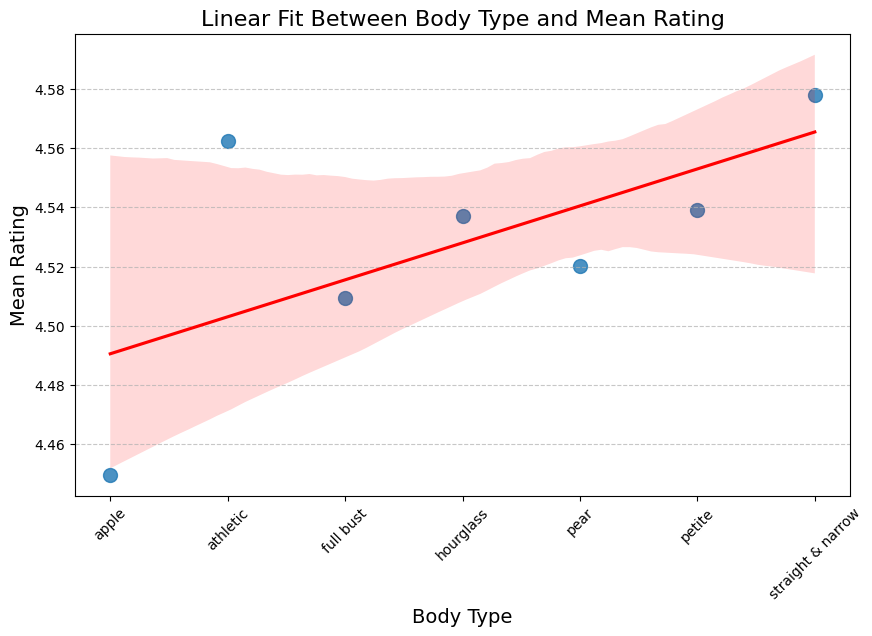

In [748]:
# Body type vs Mean rating for each body type
bodytype_rating = df.groupby('body type')['rating'].mean().reset_index()
le = LabelEncoder()
bodytype_rating['body type encoded'] = le.fit_transform(bodytype_rating['body type'])

plt.figure(figsize=(10, 6))
sns.regplot(data=bodytype_rating, x='body type encoded', y='rating', scatter_kws={'s': 100}, line_kws={'color': 'red'})
plt.xticks(ticks=bodytype_rating['body type encoded'], labels=bodytype_rating['body type'], rotation=45)
plt.title('Linear Fit Between Body Type and Mean Rating', fontsize=16)
plt.xlabel('Body Type', fontsize=14)
plt.ylabel('Mean Rating', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

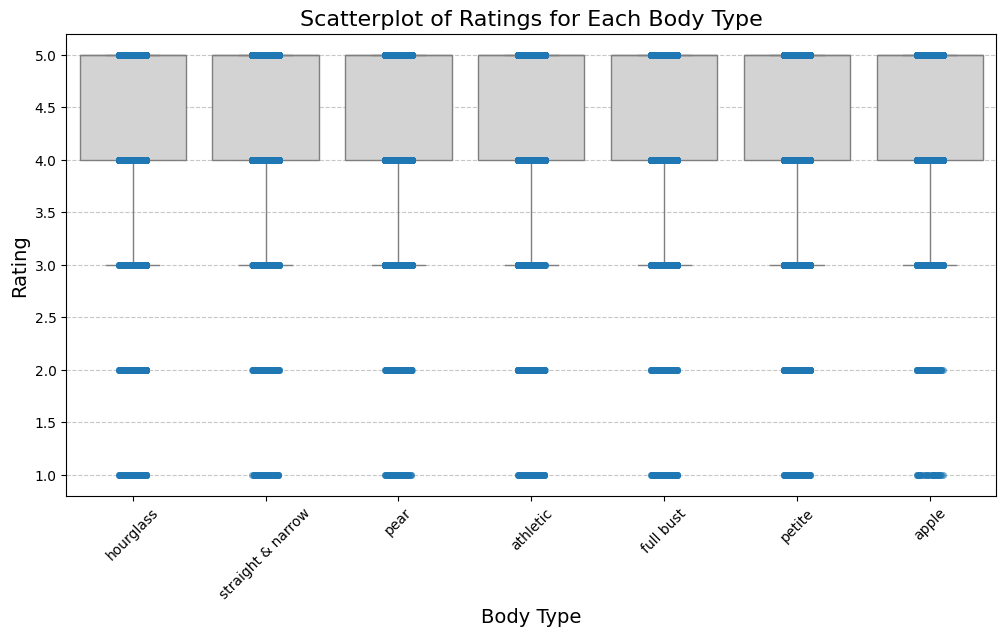

In [749]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='body type', y='rating', whis=[5, 95], showfliers=False, color='lightgrey')
sns.stripplot(data=df, x='body type', y='rating', alpha=0.6, jitter=True)
plt.xticks(rotation=45)
plt.title('Scatterplot of Ratings for Each Body Type', fontsize=16)
plt.xlabel('Body Type', fontsize=14)
plt.ylabel('Rating', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

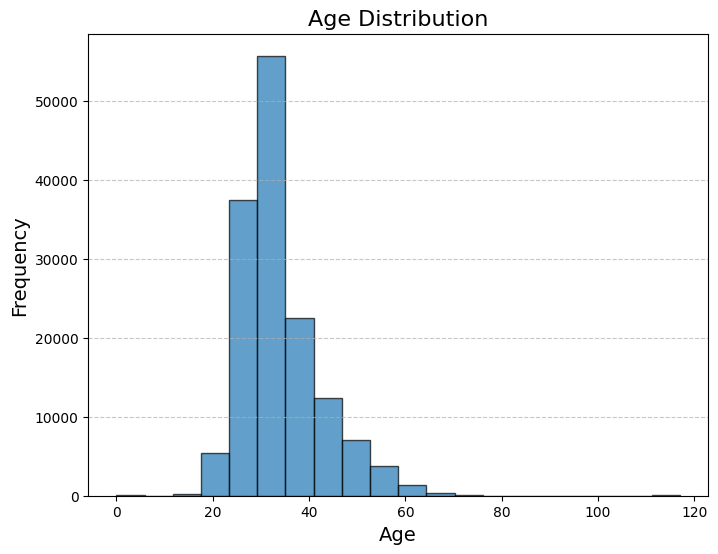

In [750]:
df['age'] = pd.to_numeric(df['age'], errors='coerce')
plt.figure(figsize=(8, 6))
plt.hist(df['age'].dropna(), bins=20, edgecolor='black', alpha=0.7)  
plt.title('Age Distribution', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

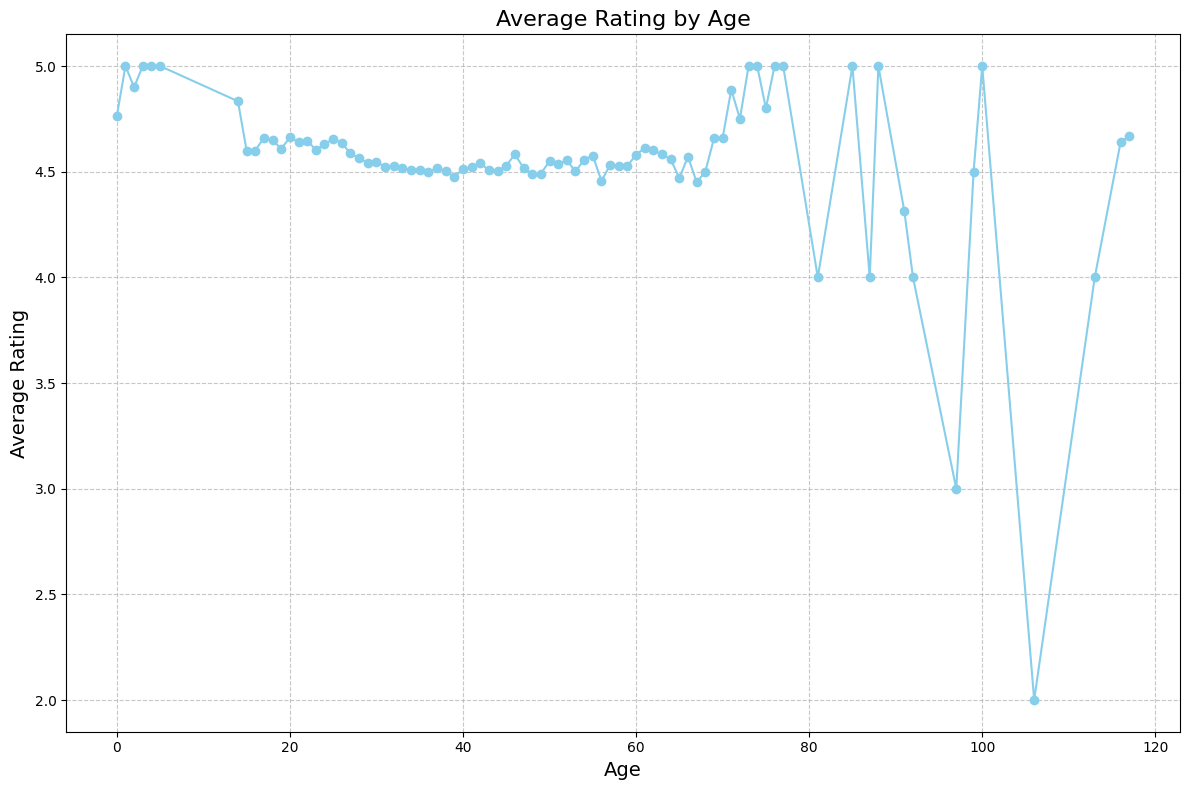

In [751]:
age_avg_rating = df.groupby('age')['rating'].mean()
age_avg_rating_sorted = age_avg_rating.sort_index()
plt.figure(figsize=(12, 8))
plt.plot(age_avg_rating_sorted.index, age_avg_rating_sorted.values, marker='o', linestyle='-', color='skyblue')
plt.title('Average Rating by Age', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

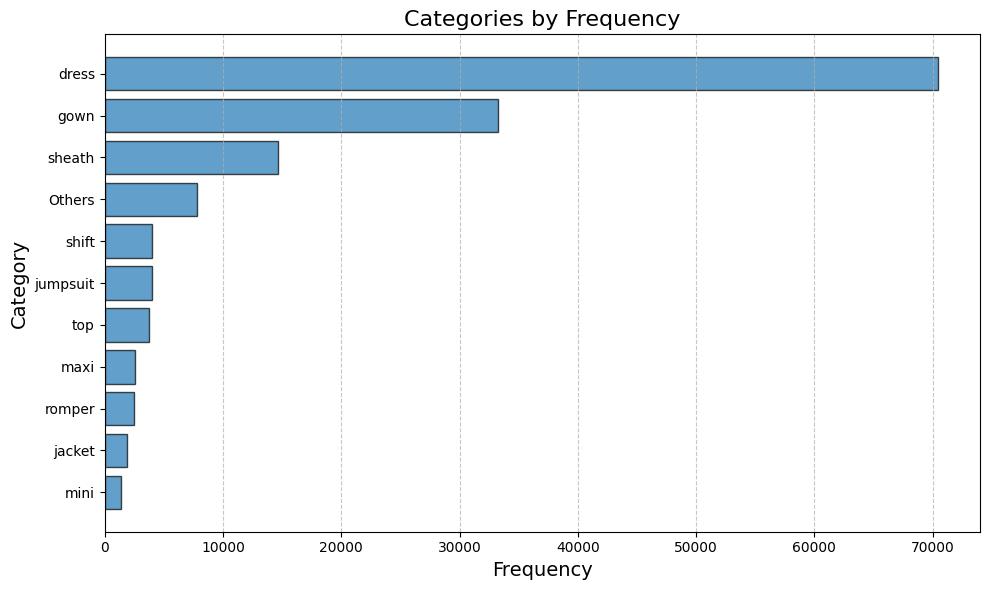

In [752]:
# All categories except for the top 10 are lumped as 'others'

top_n = 10
category_counts = df['category'].value_counts()
category_counts_top = category_counts.head(top_n)
others_count = category_counts.iloc[top_n:].sum()
category_counts_combined = pd.concat([category_counts_top, pd.Series({'Others': others_count})])
category_counts_sorted = category_counts_combined.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(category_counts_sorted.index, category_counts_sorted.values, edgecolor='black', alpha=0.7)
plt.title('Categories by Frequency', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

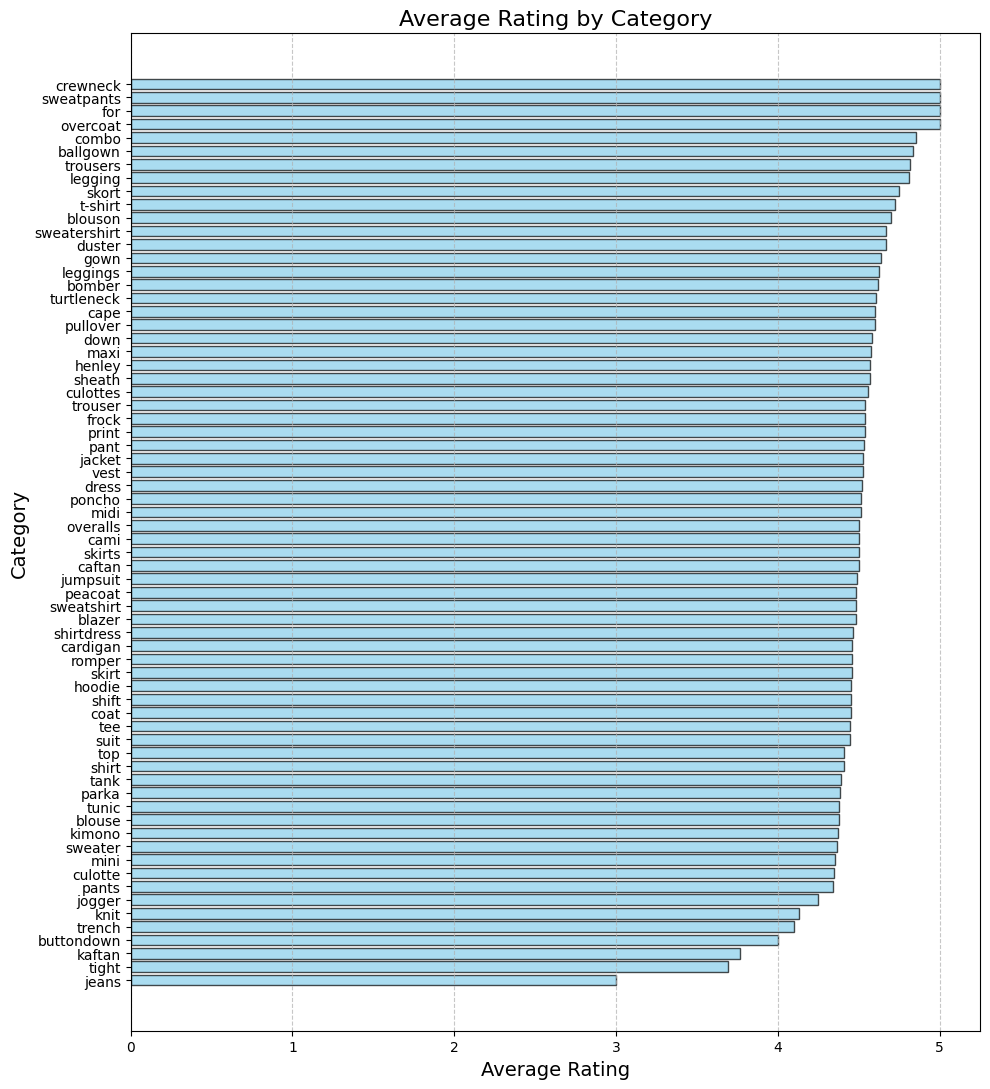

In [753]:

category_avg_rating = df.groupby('category')['rating'].mean()

category_avg_rating_sorted = category_avg_rating.sort_values(ascending=True)

plt.figure(figsize=(10, 11))
plt.barh(category_avg_rating_sorted.index, category_avg_rating_sorted.values, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Average Rating by Category', fontsize=16)
plt.xlabel('Average Rating', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


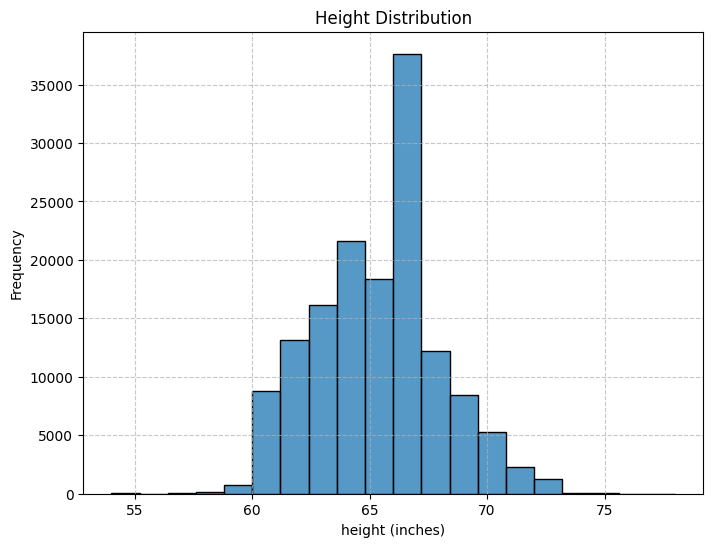

In [754]:
height_data = data_example['height'].dropna()

plt.figure(figsize=(8, 6))
sns.histplot(x=height_data, bins=20)
plt.xlabel('height (inches)')
plt.ylabel('Frequency')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.title('Height Distribution')
plt.show()


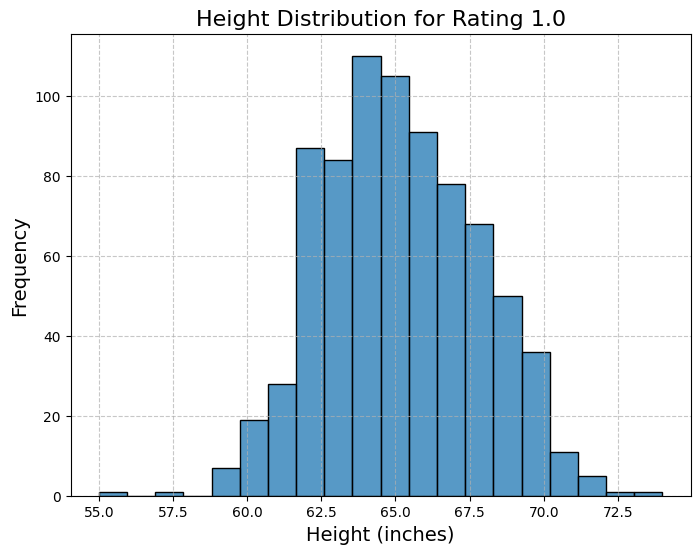

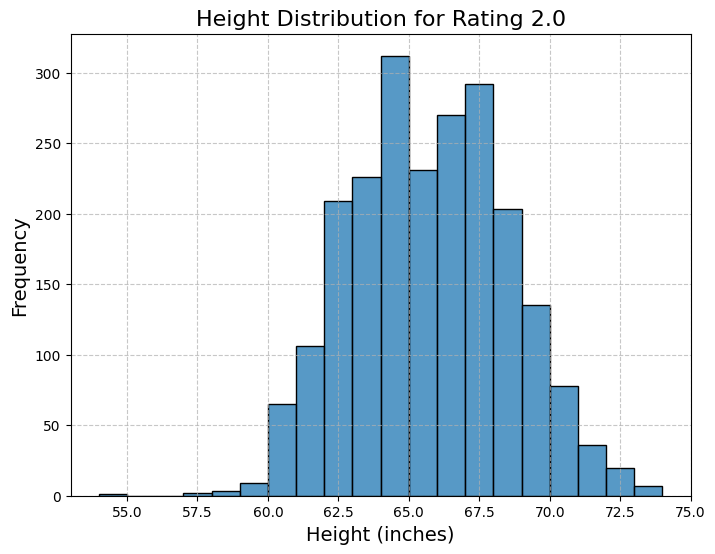

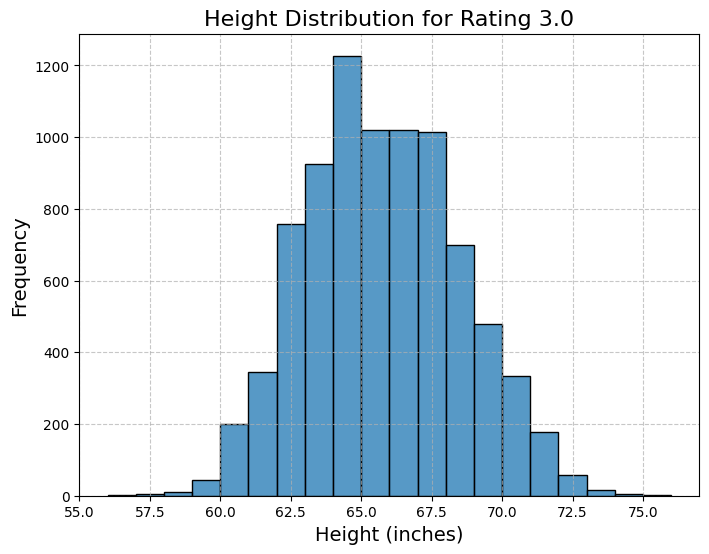

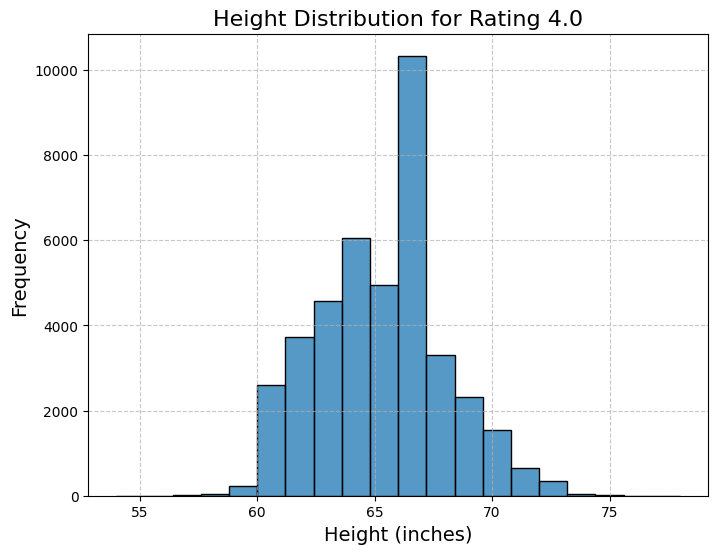

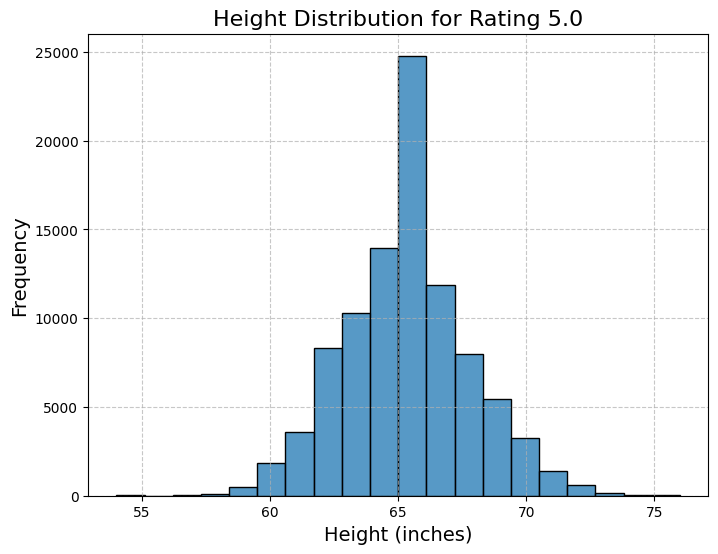

In [755]:
unique_ratings = sorted(data_example['rating'].dropna().unique())
for rating in unique_ratings:
    plt.figure(figsize=(8, 6))
    
    subset = data_example[data_example['rating'] == rating]
    sns.histplot(data=subset, x='height', bins=20, kde=False)
    
    plt.xlabel('Height (inches)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'Height Distribution for Rating {rating}', fontsize=16)
    plt.grid(axis='both', linestyle='--', alpha=0.7)
    
    plt.show()


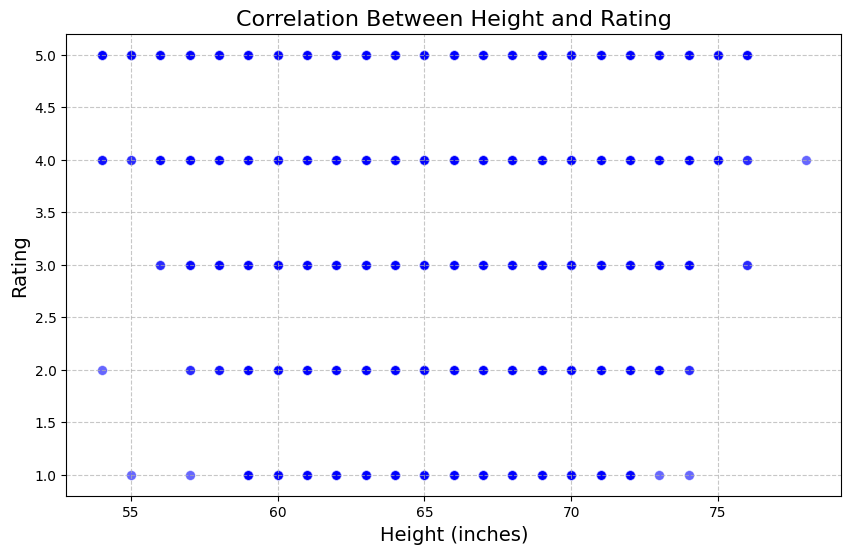

In [756]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='height', y='rating', alpha=0.6, s=50, color='blue')
plt.title('Correlation Between Height and Rating', fontsize=16)
plt.xlabel('Height (inches)', fontsize=14)
plt.ylabel('Rating', fontsize=14)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

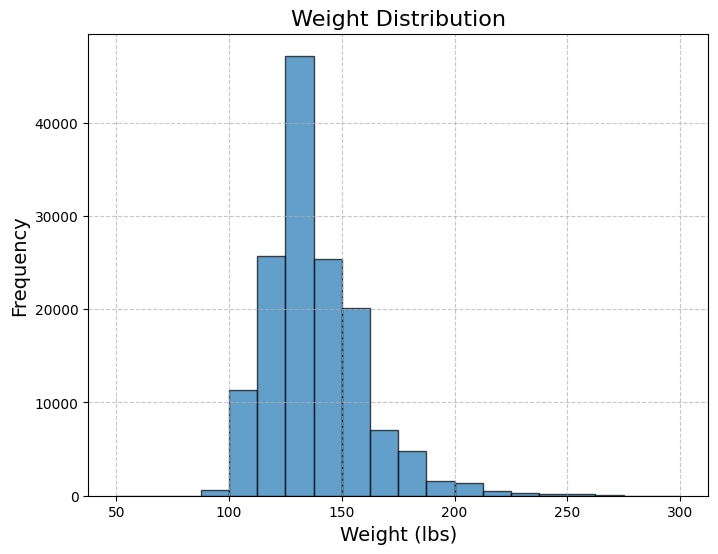

In [757]:
weight_data = data_example['weight'].dropna()
plt.figure(figsize=(8, 6))
plt.hist(weight_data, bins=20, edgecolor='black', alpha=0.7)
plt.title('Weight Distribution', fontsize=16)
plt.xlabel('Weight (lbs)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

In [758]:
data_example['rating'] = pd.to_numeric(data_example['rating'], errors='coerce')
unique_ratings = sorted(data_example['rating'].dropna().unique())
weight_counts = data_example['rating'].value_counts().sort_index()

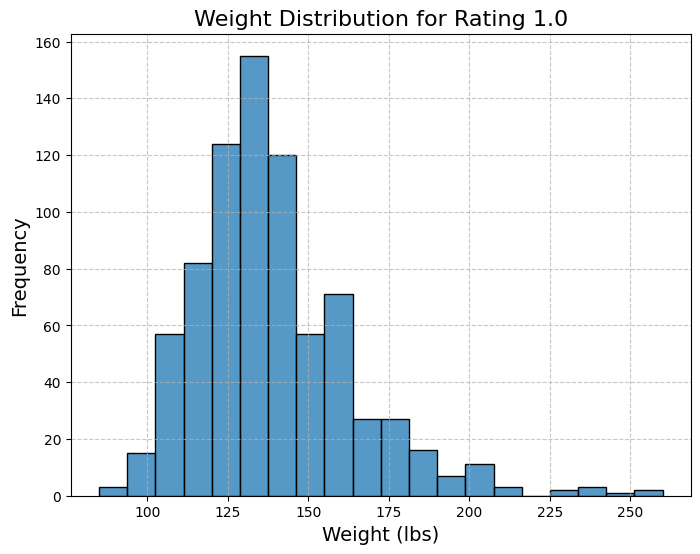

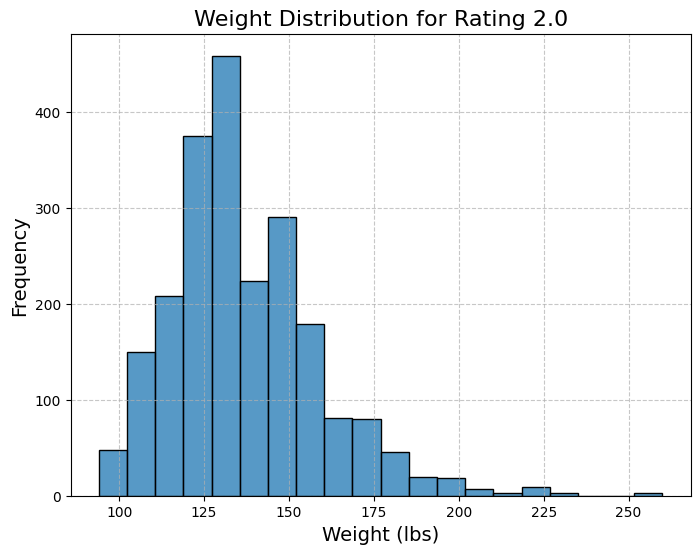

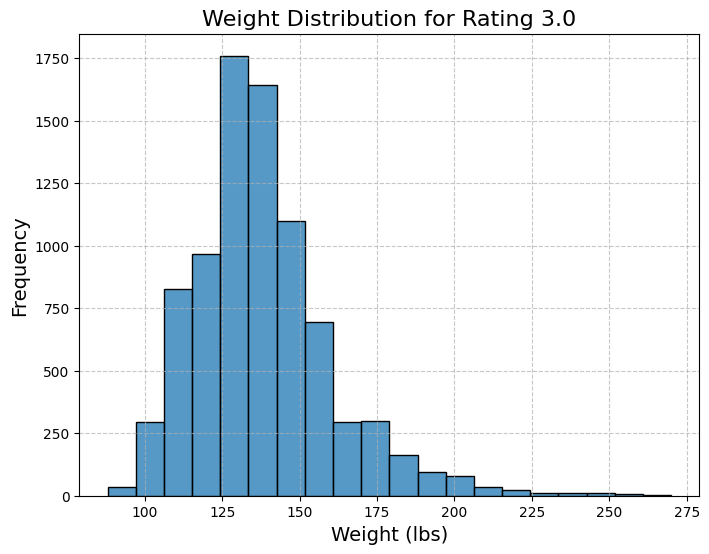

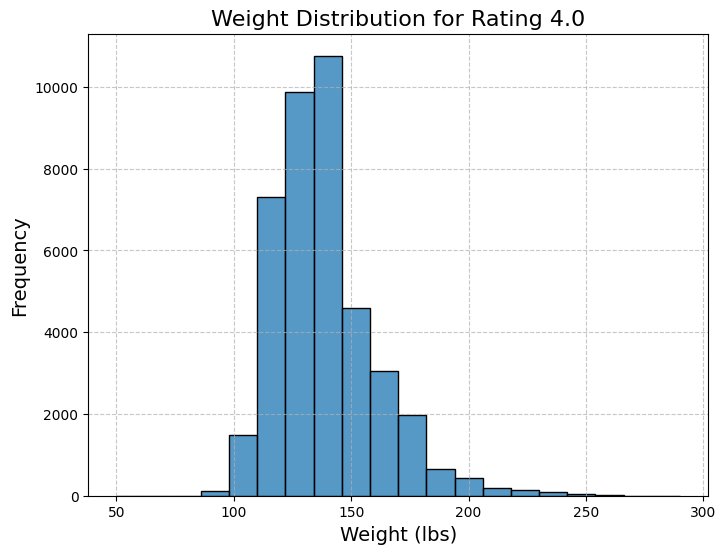

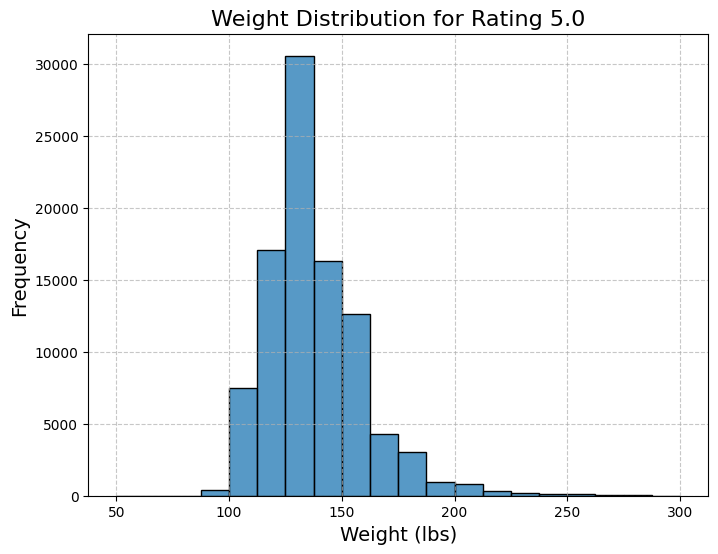

In [759]:
for rating in unique_ratings:
    plt.figure(figsize=(8, 6))
    
    subset = data_example[data_example['rating'] == rating]
    sns.histplot(data=subset, x='weight', bins=20, kde=False)
    
    plt.xlabel('Weight (lbs)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'Weight Distribution for Rating {rating}', fontsize=16)
    plt.grid(axis='both', linestyle='--', alpha=0.7)
    
    plt.show()

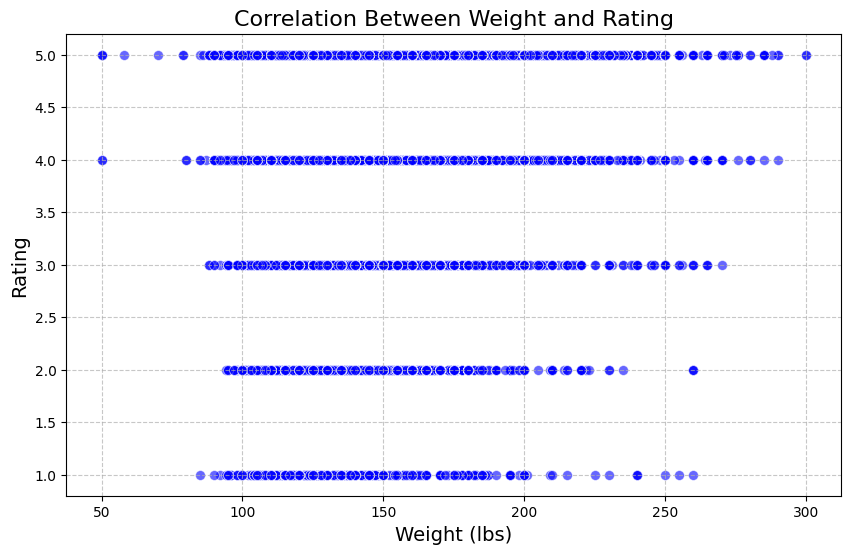

In [760]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='weight', y='rating', alpha=0.6, s=50, color='blue')
plt.title('Correlation Between Weight and Rating', fontsize=16)
plt.xlabel('Weight (lbs)', fontsize=14)
plt.ylabel('Rating', fontsize=14)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

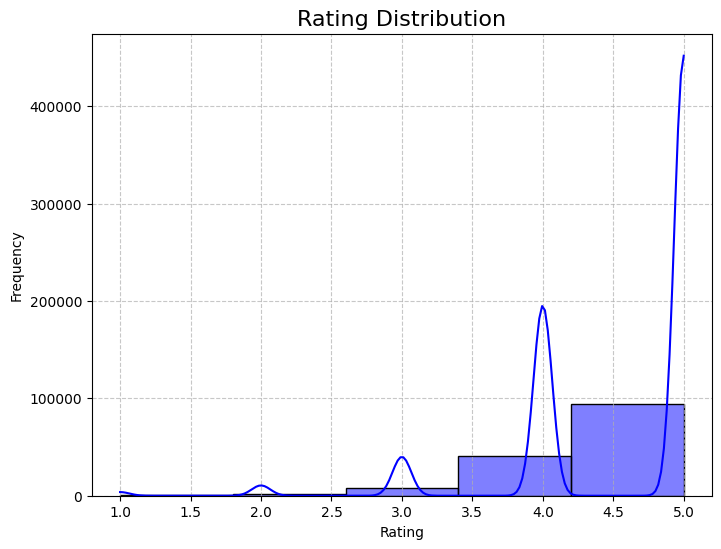

In [761]:
plt.figure(figsize=(8, 6))
sns.histplot(df['rating'], bins=5, kde=True, color='blue')
plt.title('Rating Distribution', fontsize=16)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

In [762]:
# correlation between rating and numeric features
numeric_df = data_example.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()
print(correlation_matrix['rating'].sort_values(ascending=False))

rating    1.000000
height    0.004351
weight   -0.023085
age      -0.030429
size     -0.037206
Name: rating, dtype: float64


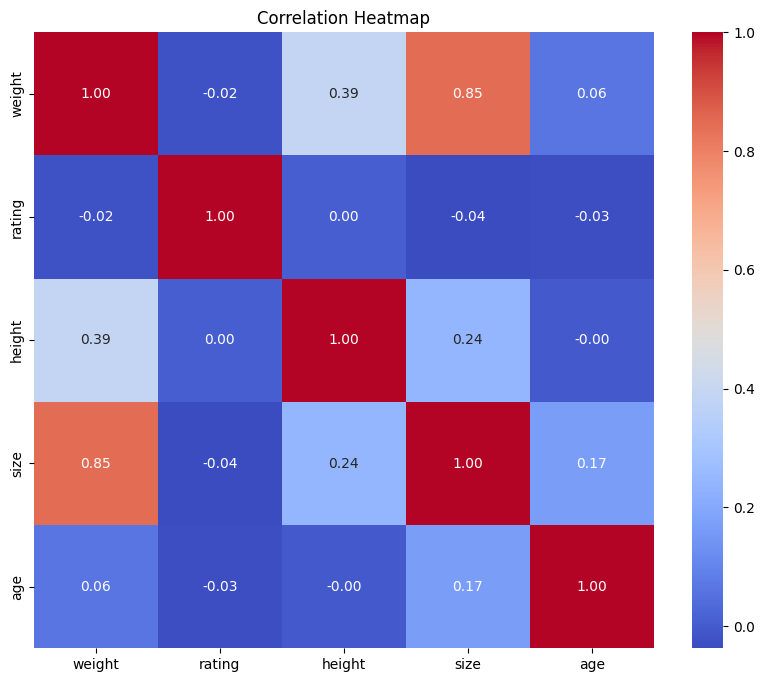

In [763]:
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [764]:
print(df.groupby('fit')['rating'].mean())
print(df.groupby('rented for')['rating'].mean())

fit
fit      4.650887
large    4.258594
small    4.211446
Name: rating, dtype: float64
rented for
date               4.468038
everyday           4.407902
formal affair      4.607030
other              4.550999
party              4.522244
party: cocktail    4.000000
vacation           4.495985
wedding            4.591549
work               4.423045
Name: rating, dtype: float64


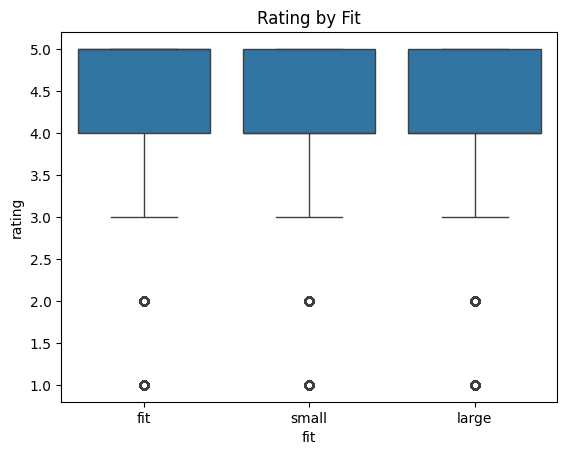

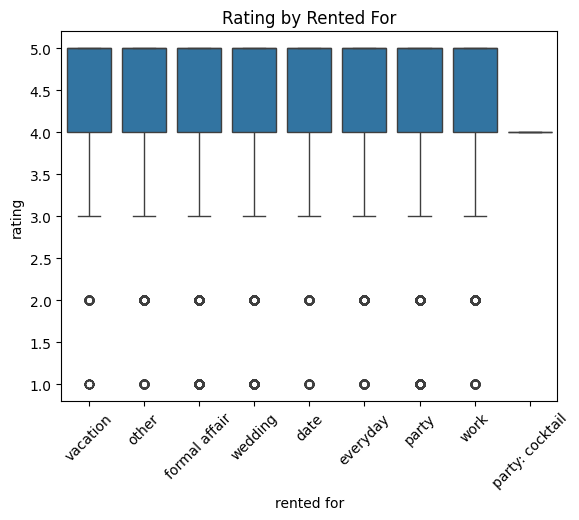

In [765]:
sns.boxplot(x='fit', y='rating', data=df)
plt.title('Rating by Fit')
plt.show()

sns.boxplot(x='rented for', y='rating', data=df)
plt.title('Rating by Rented For')
plt.xticks(rotation=45)
plt.show()

In [766]:
example_data = df.to_dict(orient='records')
ratings_exp = [d['rating'] for d in example_data]
review_lengths = [len(d['review_text']) for d in example_data]

In [767]:
print(any(x is None for x in ratings_exp))       # Check for None in ratings_exp
print(any(x is None for x in review_lengths))

False
False


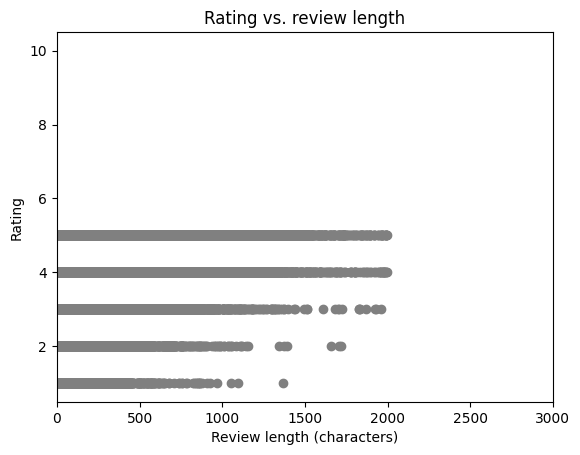

In [768]:
# Can you predict ratings from review length
plt.scatter(review_lengths, ratings_exp, color='grey')
plt.xlim(0, 3000)
plt.ylim(0.5, 10.5)
plt.xlabel("Review length (characters)")
plt.ylabel("Rating")
plt.title("Rating vs. review length")
plt.show()

In [769]:
df.describe()

,weight,rating,height,size,age
count,146381.000000,146381.000000,146381.000000,146381.000000,146381.000000
mean,137.209870,4.540992,65.263053,11.437919,34.089800
std,21.540182,0.718926,2.659230,7.826784,8.113217
min,50.000000,1.000000,54.000000,0.000000,0.000000
25%,123.000000,4.000000,63.000000,4.000000,29.000000
50%,135.000000,5.000000,65.000000,9.000000,32.000000
75%,148.000000,5.000000,67.000000,16.000000,37.000000
max,300.000000,5.000000,78.000000,58.000000,117.000000


## Predictive model

### Data processing

In [770]:
len(df)

146381

In [771]:
rent_data = df.to_dict(orient='records')
rent_data[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': 137.0,
 'rating': 5.0,
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': 68.0,
 'size': 14,
 'age': 28.0,
 'review_date': 'April 20, 2016'}

In [772]:
train_valid_ratio = 0.8
# 80% training, 20% validation
rent_data_train = rent_data[:int(len(df)*train_valid_ratio)]
rent_data_valid = rent_data[int(len(df)*train_valid_ratio):]

print(len(rent_data_train))
print(len(rent_data_valid))

117104
29277


### Baseline model

This Baseline model predicts ratings based on user-specific average ratings if the user has prior reviews; otherwise, it defaults to the global average rating.

In [773]:
userRatings = defaultdict(list)
itemRatings = defaultdict(list)
allRatings = []

for d in rent_data_train:
    rating = int(d['rating'])
    allRatings.append(rating)
    userRatings[d['user_id']].append(rating)
    itemRatings[d['item_id']].append(rating)
    

In [774]:
itemsPerUser = defaultdict(list)
usersPerItem = defaultdict(list)
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)
ratingDict = {}

for d in rent_data_train:
    itemsPerUser[d['user_id']].append(d['item_id'])
    usersPerItem[d['item_id']].append(d['user_id'])
    reviewsPerUser[d['user_id']].append(d)
    reviewsPerItem[d['item_id']].append(d)
    ratingDict[(d['user_id'], d['item_id'])] = d['rating']
    

In [775]:
globalAverage = sum(allRatings) / len(allRatings)
print("Global Mean:", globalAverage)

Global Mean: 4.541740674955595


In [776]:
ytrain = [int(d['rating']) for d in rent_data_train]
yvalid = [int(d['rating']) for d in rent_data_valid]
print(f"Length of yvalid: {len(yvalid)}")

Length of yvalid: 29277


In [777]:
ypred = []
for d in rent_data_valid:
    user_id = d['user_id']
    if user_id in userRatings:
        prediction = sum(userRatings[user_id]) / len(userRatings[user_id])
    else:
        prediction = globalAverage
        
    ypred.append(prediction)
print(f"Length of ypred: {len(ypred)}")

Length of ypred: 29277


In [778]:
mse = mean_squared_error(yvalid, ypred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(yvalid, ypred)
print(f"Baseline Model Performance:")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

Baseline Model Performance:
MSE: 0.6222953766864863
RMSE: 0.7888570064888099
MAE: 0.5736931812695399


### Linear Regression model
- Fit the prediction model using numeric features, and non numeric features that's converted by one-hot encoding

In [779]:
print(df.dtypes)

fit                object
user_id            object
bust size          object
item_id            object
weight            float64
rating            float64
rented for         object
review_text        object
body type          object
review_summary     object
category           object
height            float64
size                int64
age               float64
review_date        object
dtype: object


In [780]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
non_numeric_features = df[['fit', 'rented for', 'body type', 'category']]
# Apply one-hot encoding
encoded_features = encoder.fit_transform(non_numeric_features)
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(non_numeric_features.columns))
df_encoded = pd.concat([df.reset_index(drop=True), encoded_features_df], axis=1)
df_encoded = df_encoded.drop(columns=['fit', 'rented for', 'body type', 'category'])

In [781]:
X = df_encoded.drop(columns=['bust size', 'rating', 'review_text', 'review_summary', 'user_id', 'item_id', 'review_date']).to_numpy()

In [782]:
y = df_encoded['rating'].to_numpy()

In [783]:
Xtrain = X[:int(len(df)*train_valid_ratio)]
Xvalid = X[int(len(df)*train_valid_ratio):]

ytrain = y[:int(len(df)*train_valid_ratio)]
yvalid = y[int(len(df)*train_valid_ratio):]

In [784]:
len(Xtrain), len(Xvalid), len(ytrain), len(yvalid)

(117104, 29277, 117104, 29277)

In [785]:
lfmodel = linear_model.LinearRegression()
lfmodel.fit(Xtrain,ytrain)

LinearRegression()

In [786]:
y_pred = lfmodel.predict(Xvalid)

In [787]:
mse = mean_squared_error(yvalid, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(yvalid, y_pred)

print("Model Performance:")
print(f"  Mean Squared Error (MSE): {mse}")
print(f"  Root Mean Squared Error (RMSE): {rmse}")
print(f"  Mean Absolute Error (MAE): {mae}")

Model Performance:
  Mean Squared Error (MSE): 0.480796007524664
  Root Mean Squared Error (RMSE): 0.6933945540056282
  Mean Absolute Error (MAE): 0.5457546465244635


In [788]:
# Check if it is overfitting
y_train_pred = lfmodel.predict(Xtrain)
mse_train = mean_squared_error(ytrain, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(ytrain, y_train_pred)

print("Training model Performance (to check for overfitting):")
print(f"  Training Mean Squared Error (MSE): {mse_train}")
print(f"  Training Root Mean Squared Error (RMSE): {rmse_train}")
print(f"  Training Mean Absolute Error (MAE): {mae_train}")

Training model Performance (to check for overfitting):
  Training Mean Squared Error (MSE): 0.4758429397983148
  Training Root Mean Squared Error (RMSE): 0.6898136993408545
  Training Mean Absolute Error (MAE): 0.5442563548979188


### Latent Factor Model (Surprise)
- Predictor model based on just user and item interactions

In [789]:
from surprise.model_selection import train_test_split, GridSearchCV


In [790]:
rent_data_svd = [(d['user_id'], d['item_id'], d['rating']) for d in rent_data]

In [791]:
reader = Reader(line_format='user item rating', sep=',')
data_surprise = Dataset.load_from_df(pd.DataFrame(rent_data_svd, columns=['user', 'item', 'rating']), reader=reader)

In [792]:
trainset, testset = train_test_split(data_surprise, test_size=0.2, random_state=42)

In [793]:
modelsvd = SVD()
modelsvd.fit(trainset)

In [794]:
predictions = modelsvd.test(testset)

In [795]:
y_label = [p.r_ui for p in predictions]
y_pred = [p.est for p in predictions]

In [796]:
mse = mean_squared_error(y_label, y_pred)
rmse_value = np.sqrt(mse)
mae_value = mean_absolute_error(y_label, y_pred)

In [797]:
print("SVD Model Performance:")
print(f"  Mean Squared Error (MSE): {mse:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_value:.4f}")
print(f"  Mean Absolute Error (MAE): {mae_value:.4f}")

SVD Model Performance:
  Mean Squared Error (MSE): 0.5048
  Root Mean Squared Error (RMSE): 0.7105
  Mean Absolute Error (MAE): 0.5525


In [798]:
'''
userIDs = {}
itemIDs = {}
interactions = []

for d in rent_data:
    u = d['user_id']
    i = d['item_id']
    r = d['rating']
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)
    interactions.append((u,i,r))
'''

"\nuserIDs = {}\nitemIDs = {}\ninteractions = []\n\nfor d in rent_data:\n    u = d['user_id']\n    i = d['item_id']\n    r = d['rating']\n    if not u in userIDs: userIDs[u] = len(userIDs)\n    if not i in itemIDs: itemIDs[i] = len(itemIDs)\n    interactions.append((u,i,r))\n"

In [799]:
'''
X = interactions
y = [i[2] for i in interactions]
'''

'\nX = interactions\ny = [i[2] for i in interactions]\n'

In [800]:
'''
itemsPerUser = defaultdict(list)
usersPerItem = defaultdict(list)
for u,i,r in Xtrain:
    itemsPerUser[u].append(i)
    usersPerItem[i].append(u)
'''

'\nitemsPerUser = defaultdict(list)\nusersPerItem = defaultdict(list)\nfor u,i,r in Xtrain:\n    itemsPerUser[u].append(i)\n    usersPerItem[i].append(u)\n'

### Factorization Machine (fastFM)
- User Item only model


In [811]:
userIDs,itemIDs = {},{}

for d in rent_data:
    u,i = d['user_id'],d['item_id']
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)

nUsers,nItems = len(userIDs),len(itemIDs)

In [812]:
X = scipy.sparse.lil_matrix((len(df), nUsers + nItems))

In [813]:
for idx, row in enumerate(rent_data):
    user = userIDs[row['user_id']]
    item = itemIDs[row['item_id']]
    X[idx, user] = 1
    X[idx, nUsers + item] = 1

In [814]:
print(f"Extended Design Matrix Shape: {X.shape}")

Extended Design Matrix Shape: (146381, 83083)


In [815]:
y = df['rating'].to_numpy()

In [816]:
X_train = X[:int(len(df)*train_valid_ratio)]
X_valid = X[int(len(df)*train_valid_ratio):]

y_train = y[:int(len(df)*train_valid_ratio)]
y_valid = y[int(len(df)*train_valid_ratio):]


In [817]:
fm = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=5, l2_reg_w=0.1, l2_reg_V=0.5)

In [818]:
fm.fit(X_train, y_train)
y_pred = fm.predict(X_valid)

In [819]:
y_pred[:10]

array([4.73817167, 5.37024058, 5.2404694 , 4.6928337 , 4.30643968,
       5.35793214, 4.55589959, 4.92349882, 5.54833793, 4.52003483])

In [820]:
mse = mean_squared_error(y_valid, y_pred)
rmse_value = np.sqrt(mse)
mae_value = mean_absolute_error(y_valid, y_pred)

In [821]:
print("FM Model Performance:")
print(f"  Mean Squared Error (MSE): {mse:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_value:.4f}")
print(f"  Mean Absolute Error (MAE): {mae_value:.4f}")

FM Model Performance:
  Mean Squared Error (MSE): 0.6450
  Root Mean Squared Error (RMSE): 0.8031
  Mean Absolute Error (MAE): 0.5997


### Factorization Machine (fastFM)
- User, item, feature

In [ ]:
userIDs,itemIDs = {},{}

# Change this to test certain feature
feature_name = 'rented for'
featureID = {}

for d in rent_data:
    u,i = d['user_id'],d['item_id']
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)

nUsers,nItems = len(userIDs),len(itemIDs)